In [1]:
from sage.all import *
import scipy.stats
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
y = var('y')

In [3]:
norm_pdf = exp(-(y ** 2) / 2) / sqrt(2 * pi)
t = var('t')
norm_cdf = integrate(norm_pdf, y, -infinity, t).full_simplify()
norm_cdf

In [5]:
a, xi, w = var('a, xi, w')
assume(xi < 0)
assume(a > 0)
assume(w > 0)
sn_pdf_normalized = 2 * norm_pdf * norm_cdf.subs(t == (a*y))
sn_pdf_normalized._sympy_()

sqrt(2)*(erf(sqrt(2)*a*y/2) + 1)*exp(-y**2/2)/(2*sqrt(pi))

In [6]:
x = var('x')
xt = (x - xi) / w
sn_pdf = sn_pdf_normalized.subs(y == xt) / w
sn_pdf._sympy_()

sqrt(2)*(erf(sqrt(2)*a*(x - xi)/(2*w)) + 1)*exp(-(x - xi)**2/(2*w**2))/(2*sqrt(pi)*w)

In [7]:
log_norm_pdf = -(y ** 2) / 2 - log(sqrt(2 * pi))
log_norm_cdf = function('lognormcdf')
log_sn_pdf = log(2) - log(w) + log_norm_pdf.subs(y == xt) + log_norm_cdf(a * xt)
# log_sn_pdf = log(2) + log_norm_pdf.subs(y==x) + log_norm_cdf(a * x)
log_sn_pdf._sympy_()

lognormcdf(a*(x - xi)/w) - log(w) - log(sqrt(2)*sqrt(pi)) + log(2) - (x - xi)**2/(2*w**2)

In [8]:
sn_ds = []
for i in range(5):
    sn_ds.append(derivative(log_sn_pdf, x, i))

In [9]:
g1, g2, g3 = var('g1, g2, g3')
g1

g1

In [10]:
from IPython.display import display
for i in range(1,4):
    print(f'\n {i}')
    display(sn_ds[i])


 1


a*D[0](lognormcdf)(a*(x - xi)/w)/w - (x - xi)/w^2


 2


a^2*D[0, 0](lognormcdf)(a*(x - xi)/w)/w^2 - 1/w^2


 3


a^3*D[0, 0, 0](lognormcdf)(a*(x - xi)/w)/w^3

In [63]:
psi1 = (norm_pdf / norm_cdf.subs(t == y)).full_simplify()
psi2 = -psi1 * (y + psi1)
psi3 = -psi2 * (y + psi1) - psi1 * (1 + psi2)
psi4 = -psi3 * (y + 2 * psi1) - 2 * psi2 * (1 + psi2)
psi5 = -psi4 * (y + 2 * psi1) - 3 * psi3 * (1 + 2 * psi2)
psi = [0, psi1, psi2, psi3, psi4, psi5]
for i in range(1,5):
    print((derivative(psi[i], y) - psi[i + 1]).full_simplify())


0
0
0
0


In [59]:
psi_vars = [var(f'p{i}') for i in range(1,6)]
psi_vars

[p1, p2, p3, p4, p5]

In [65]:
psi_sn_ds = [0 for i in range(4)]
for i in range(1, 4):
    subs_term = log_norm_cdf(a*xt)
    for j in range(i):
        subs_term = derivative(subs_term, x)
    psi_sn_ds[i] = sn_ds[i].subs(subs_term == psi_vars[i-1] * (a/w) ** i)
psi_sn_ds

[0, a*p1/w - (x - xi)/w^2, a^2*p2/w^2 - 1/w^2, a^3*p3/w^3]

In [14]:
psi_sn_ds = [0 for i in range(4)]
for i in range(1, 4):
    subs_term = log_norm_cdf(a*xt)
    for j in range(i):
        subs_term = derivative(subs_term, x)
    psi_sn_ds[i] = sn_ds[i].subs(subs_term == psi[i].subs(y == a * xt) * (a/w) ** i)

In [16]:
objective = (
    (psi_sn_ds[1].subs(x == 0) - g1) ** 2
    + (psi_sn_ds[2].subs(x == 0) - g2) ** 2
    + (psi_sn_ds[3].subs(x == 0) - g3) ** 2
)


In [17]:
example = (-0.009716262625455222, -0.25432153325092355, -0.18668414543379036)
soln6 = [1.6663929335692391, 3.757723064525265, -3.3302539408014247]
float(objective.subs(
    g1 == example[0],
    g2 == example[1],
    g3 == example[2],
    x == 0,
    xi == soln6[0],
    w == soln6[1],
    a == soln6[2]
))

1.5230458221804384e-09

In [19]:
grad = [
    derivative(objective, var)
    for var in [xi, w, a]
]
hessian = [
    [derivative(grad[i], var)
    for i in range(3)]
    for var in [xi, w, a]
]

In [29]:
subs = [
    ('math.', '')
]
vars = [
    ('a2', 'a**2'),
    ('xi2', 'xi**2'),
    ('w2', 'w**2'),
    ('xt', 'a*xi/w'),
    ('xt2', 'a2*xi2/w2'),
    ('ext2', 'exp((1/2)*xt2'),
    ('erfxt', 'erf((1/2)*sqrt(2)*xt)'),
]
code = sp.printing.lambdarepr.lambdarepr(hessian[0][0]._sympy_())
for s in subs:
    code = code.replace(s[0], s[1])
for v in vars:
    code = code.replace(v[1], v[0])
code

'2*a**6*(sqrt(2)*a2*xi2*(-a2*xi*ext2)*erfxt/w2 + a2*xi*ext2)/w2 - sqrt(2)*a/(sqrt(pi)*w))/(sqrt(pi)*w2*(-ext2)*erfxt + ext2))**2) - 2*sqrt(2)*a2*xi/(sqrt(pi)*w2*(-ext2)*erfxt + ext2))) - 12*a*xi*(-a2*xi*ext2)*erfxt/w2 + a2*xi*ext2)/w2 - sqrt(2)*a/(sqrt(pi)*w))/(pi*w*(-ext2)*erfxt + ext2))**3) + 6*a/(pi*w*(-ext2)*erfxt + ext2))**2) - sqrt(2)*(-a2*xi*ext2)*erfxt/w2 + a2*xi*ext2)/w2 - sqrt(2)*a/(sqrt(pi)*w))/(sqrt(pi)*(-ext2)*erfxt + ext2))**2) + 12*sqrt(2)*(-a2*xi*ext2)*erfxt/w2 + a2*xi*ext2)/w2 - sqrt(2)*a/(sqrt(pi)*w))/(pi**(3/2)*(-ext2)*erfxt + ext2))**4))**2/w**6 + 2*a**4*(sqrt(2)*a*xi*(-a2*xi*ext2)*erfxt/w2 + a2*xi*ext2)/w2 - sqrt(2)*a/(sqrt(pi)*w))/(sqrt(pi)*w*(-ext2)*erfxt + ext2))**2) - sqrt(2)*a/(sqrt(pi)*w*(-ext2)*erfxt + ext2))) - 4*(-a2*xi*ext2)*erfxt/w2 + a2*xi*ext2)/w2 - sqrt(2)*a/(sqrt(pi)*w))/(pi*(-ext2)*erfxt + ext2))**3))**2/w**4 - 2*a**3*(-a**3*(sqrt(2)*a2*xi2/(sqrt(pi)*w2*(-ext2)*erfxt + ext2))) - 6*a*xi/(pi*w*(-ext2)*erfxt + ext2))**2) - sqrt(2)/(sqrt(pi)*(-ext2)*erf

In [63]:
# xiv, wv, av = soln6
# float(log_sn_pdf.subs(
#     lognormcdf(a * xt) == scipy.stats.norm.logcdf(-av * xiv / wv)
# ).subs(x == 0, xi == xiv, w == wv, a == av))
# float(sn_ds[1].subs(
#     derivative(lognormcdf(a * xt), x) == psi1.subs(y == a * xt) * a / w
# ).subs(x==0, xi==xiv, w==wv, a==av))

-1.7203531931928617

In [110]:
py_sn_ds = [sp.lambdify((x, xi, w, a), psi_sn_ds[i]._sympy_()) for i in range(1,4)]
for i in range(3):
    print(py_sn_ds[i](0, *soln6))

-0.009723111857446579
-0.25431938266802934
-0.1867225056845263


In [135]:
psi_sn_ds[1]

sqrt(2)*a/(sqrt(pi)*(erf(1/2*sqrt(2)*a*(x - xi)/w)*e^(1/2*a^2*(x - xi)^2/w^2) + e^(1/2*a^2*(x - xi)^2/w^2))*w) - (x - xi)/w^2

In [136]:
psi_sn_ds[2]

-a^2*(sqrt(2)*a*(x - xi)/(sqrt(pi)*(erf(1/2*sqrt(2)*a*(x - xi)/w)*e^(1/2*a^2*(x - xi)^2/w^2) + e^(1/2*a^2*(x - xi)^2/w^2))*w) + 2/(pi*(erf(1/2*sqrt(2)*a*(x - xi)/w)*e^(1/2*a^2*(x - xi)^2/w^2) + e^(1/2*a^2*(x - xi)^2/w^2))^2))/w^2 - 1/w^2

In [134]:
solve(psi_sn_ds[1].subs(x==0, w == soln6[1], a == soln6[2]) - example[0] == 0, xi)

[xi == -167956123/26424886230406401361949*(21585696725824*(sqrt(pi)*erf(19122819/43154822*sqrt(2)*xi) + sqrt(pi))*e^(13962373/35553640*xi^2) - 1968880720903707*sqrt(2))*e^(-13962373/35553640*xi^2)/(sqrt(pi)*erf(19122819/43154822*sqrt(2)*xi) + sqrt(pi))]

In [132]:
psi_sn_ds[1].subs(x==0, w == soln6[1], a == soln6[2]) - example[0]

0.0708191091074423*xi - 0.886242515378699*sqrt(2)/(sqrt(pi)*(erf(0.4431212576893495*sqrt(2)*xi)*e^(0.39271289803238185*xi^2) + e^(0.39271289803238185*xi^2))) + 0.009716262625455222

In [120]:
solve([psi_sn_ds[1].subs(x==0) == example[0]], x)

[]

In [113]:
residual = [lambda *args: (py_sn_ds[i](0, *args) - example[i]) for i in range(3)]
objective = lambda *args: np.sum([residual[i](*args) ** 2 for i in range(3)])
objective(*soln6)

4.414526509574182e-09

<lambdifygenerated-21>:2: RuntimeWarning: divide by zero encountered in divide
  return a**3*(sqrt(2)*a**2*(x - xi)**2/(sqrt(pi)*w**2*(exp((1/2)*a**2*(x - xi)**2/w**2)*erf((1/2)*sqrt(2)*a*(x - xi)/w) + exp((1/2)*a**2*(x - xi)**2/w**2))) + 6*a*(x - xi)/(pi*w*(exp((1/2)*a**2*(x - xi)**2/w**2)*erf((1/2)*sqrt(2)*a*(x - xi)/w) + exp((1/2)*a**2*(x - xi)**2/w**2))**2) - sqrt(2)/(sqrt(pi)*(exp((1/2)*a**2*(x - xi)**2/w**2)*erf((1/2)*sqrt(2)*a*(x - xi)/w) + exp((1/2)*a**2*(x - xi)**2/w**2))) + 4*sqrt(2)/(pi**(3/2)*(exp((1/2)*a**2*(x - xi)**2/w**2)*erf((1/2)*sqrt(2)*a*(x - xi)/w) + exp((1/2)*a**2*(x - xi)**2/w**2))**3))/w**3
<lambdifygenerated-21>:2: RuntimeWarning: invalid value encountered in divide
  return a**3*(sqrt(2)*a**2*(x - xi)**2/(sqrt(pi)*w**2*(exp((1/2)*a**2*(x - xi)**2/w**2)*erf((1/2)*sqrt(2)*a*(x - xi)/w) + exp((1/2)*a**2*(x - xi)**2/w**2))) + 6*a*(x - xi)/(pi*w*(exp((1/2)*a**2*(x - xi)**2/w**2)*erf((1/2)*sqrt(2)*a*(x - xi)/w) + exp((1/2)*a**2*(x - xi)**2/w**2))**2) - sqrt(2)/(sqrt

IndexError: list index out of range

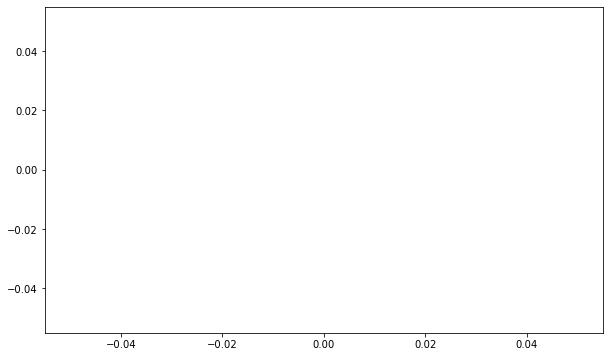

In [109]:
plt.figure(figsize=(10,6))
avs = np.linspace(0, 5, 51)
plt.plot(avs, residual[1](avs, 0, 1.0), 'k-', label='1')
plt.plot(avs, residual[2](avs, 0, 1.0), 'k--', label='2')
plt.plot(avs, residual[3](avs, 0, 1.0)/10, 'k-.', label='3')
plt.legend()
plt.show()

In [54]:
# soln = solve([sn_ds[1] == gamma1, sn_ds[2] == gamma2, sn_ds[3] == gamma3], a, xi, w)